# Project of Cognition and Computation - Lupi Riccardo 2205445

##Introduction

### Setup of the Project
As first step we download two simple scripts implementing a Deep Belief Network in PyTorch and import a few useful Python libraries.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import torch
import math
import scipy.cluster as cluster
import torch.nn.functional as functional
import numpy as np
import seaborn as sns
import torchvision as tv
from tqdm.notebook import tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import sklearn.preprocessing

from DBN import DBN

Then we select the kind of hardware device that is going to be used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

False
cpu


## Dataset: Fashion-MNIST

60k train/10k test 28x28 grayscale images (10 clothing classes: T-shirt to Ankle boot). Normalized [0,1], GPU-ready. Chosen over MNIST for semantic variety (project req: beyond digits).


In [ ]:
# Project datasets Fashion-MNIST
fashion_tr = tv.datasets.FashionMNIST(root='./mnist', train=True, download=True)
fashion_te = tv.datasets.FashionMNIST(root='./mnist', train=False, download=True)

fashion_tr.data = fashion_tr.data / 255
fashion_te.data = fashion_te.data / 255

fashion_tr.data = fashion_tr.data.to(device)
fashion_te.data = fashion_te.data.to(device)

fashion_tr.targets = fashion_tr.targets.to(device)
fashion_te.targets = fashion_te.targets.to(device)

print(f"Fashion-MNIST - Train: {fashion_tr.data.shape}, Test: {fashion_te.data.shape}")
print("Classes: 0=T-shirt/top, 1=Trouser, 2=Pullover, 3=Dress, 4=Coat, 5=Sandal, 6=Shirt, 7=Sneaker, 8=Bag, 9=Ankle boot")



100%|██████████| 26.4M/26.4M [00:01<00:00, 17.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.41MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.23MB/s]


Fashion-MNIST - Train: torch.Size([60000, 28, 28]), Test: torch.Size([10000, 28, 28])
Classes: 0=T-shirt/top, 1=Trouser, 2=Pullover, 3=Dress, 4=Coat, 5=Sandal, 6=Shirt, 7=Sneaker, 8=Bag, 9=Ankle boot


Let's visualize one training image:

The image shows the clothing:  Ankle boot


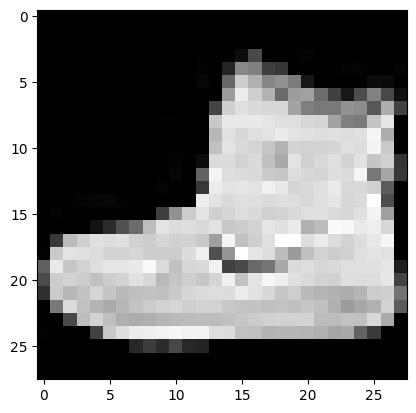

In [ ]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = 0
img = fashion_tr.data[idx].cpu()  # NB: to plot the data, we need to move it back from the GPU memory!
print("The image shows the clothing: ", class_names[(fashion_tr.targets[idx])])
plt.imshow(img , cmap = 'gray')
plt.show()



Following are the distribution of the classes on the test and training set

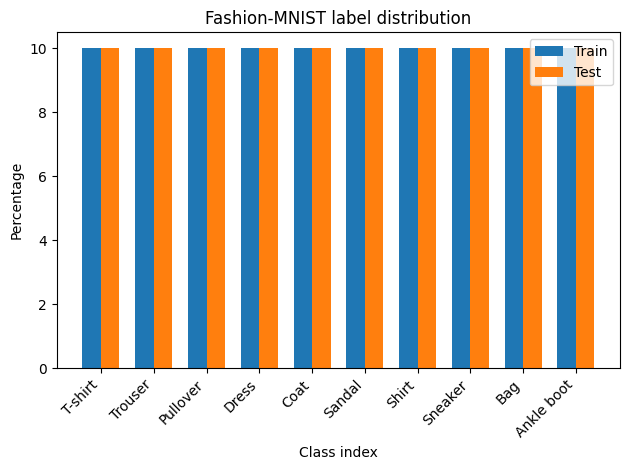

In [ ]:
classes = list(range(10))
# Move to CPU
fashion_targets_train = fashion_tr.targets.cpu().numpy()
fashion_targets_test  = fashion_te.targets.cpu().numpy()

x = np.arange(10)
width = 0.35

train_perc = [int(np.sum(fashion_targets_train == i) / len(fashion_targets_train) * 100) for i in classes]
test_perc  = [int(np.sum(fashion_targets_test == i) / len(fashion_targets_test) * 100) for i in classes]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_perc, width, label='Train')
rects2 = ax.bar(x + width/2, test_perc, width, label='Test')

ax.set_ylabel('Percentage')
ax.set_xlabel('Class index')
ax.set_title('Fashion-MNIST label distribution')
ax.legend()

plt.xticks(classes, class_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()


As we can see from the graph, Fashion-MNIST has perfectly balanced class distribution.

## DBN Architecture & Training

3-layer stack of RBMs: visible=784 (flattened 28x28), hidden=[500,600,1000] (tuned larger vs. labs for better Fashion-MNIST reps). Unsupervised max-likelihood via contrastive divergence (k=1). 50 epochs monitor rec error.

In [ ]:
dbn_fashion = DBN(visible_units=28*28,
                hidden_units=[500, 600, 1000],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())


Now we train the model

In [ ]:
num_epochs = 50
batch_size = 125

dbn_fashion.train_static(
    fashion_tr.data,
    fashion_tr.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8299     |0.0821       |338.0337   |6.9333     |
|20    |1.7192     |0.0758       |324.0299   |5.4783     |
|30    |1.6904     |0.0764       |320.3891   |4.8866     |
|40    |1.6776     |0.0773       |318.8246   |5.5412     |
|50    |1.6702     |0.0764       |317.6099   |5.7612     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8893     |0.0302       |164.4584   |2.9553     |
|20    |0.8224     |0.0281       |153.7755   |2.5710     |
|30    |0.8044     |0.0272       |150.6698   |2.3255     |
|40    |0.7958     |0.0273       |148.8988   |2.3796     |
|50    |0.7901     |0.0267       |147.0669   |2.8509     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.7357     |0.0245       |168.5088   |2.8849     |
|20    |0.6447     |0.0216       |152.2718   |2.267

## Visualizing receptive fields


In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

## Layer 1 Receptive Fields

Extract W (784x500), threshold >0.1, min-max scale [0,1]. Plot first 100 as 28x28 images: expect edges/textures tuned to clothing patterns (e.g., lines for trousers).

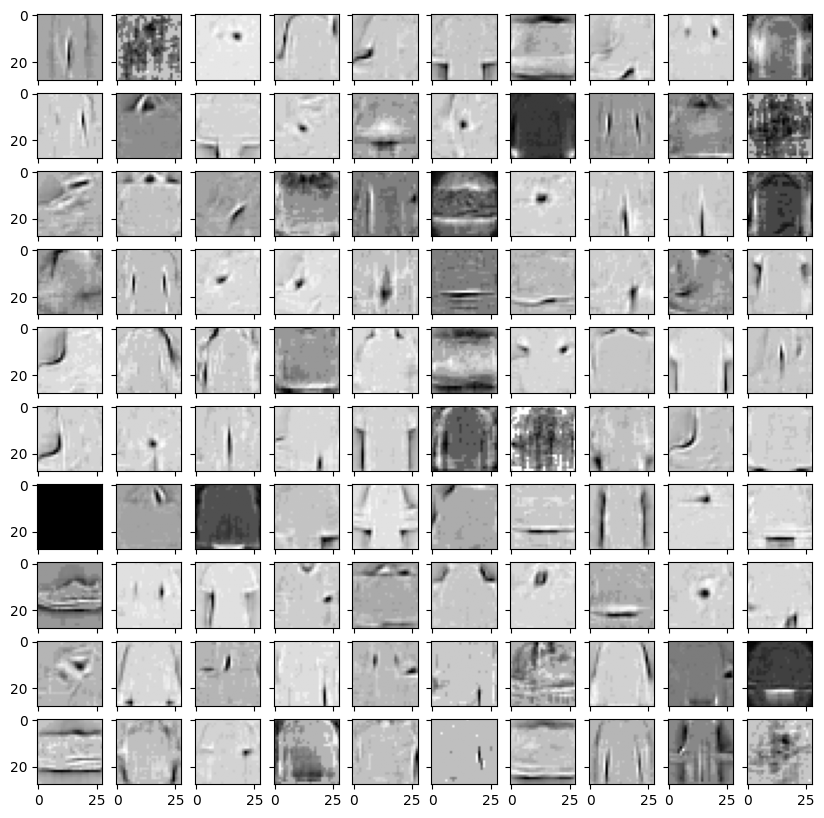

In [ ]:
#first layer visualization
w1 = get_weights(dbn_fashion, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

## Layers 2-3 Receptive Fields

Repeat for deeper RBMs: expect more abstract/complex patterns (e.g., garment shapes in L3). Threshold reveals sparse, interpretable features.

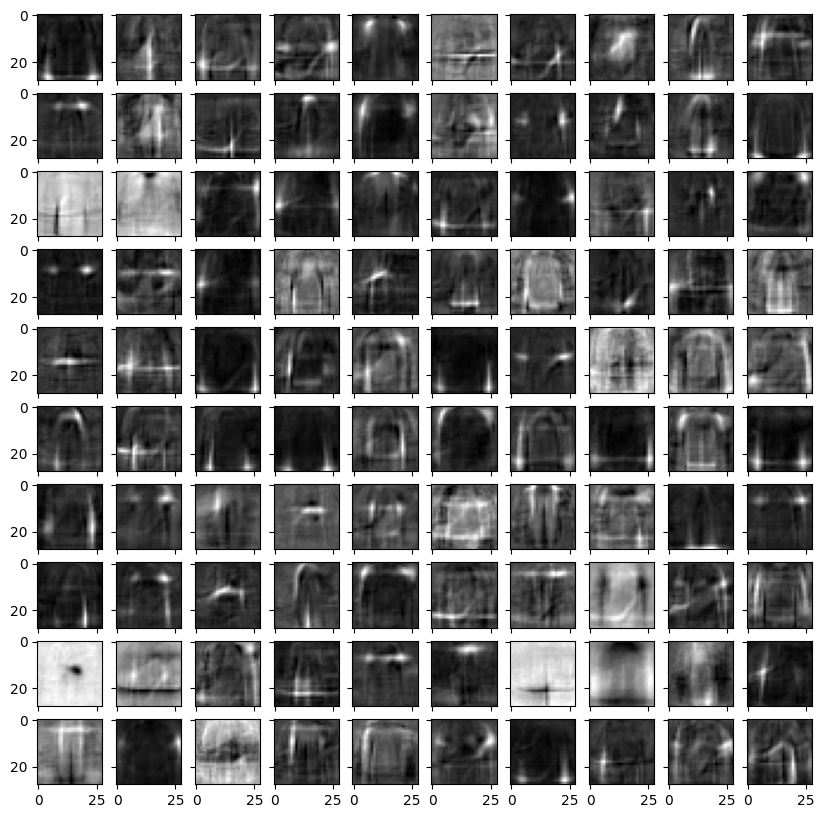

In [ ]:
#second layer
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

In [ ]:
#third layer
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)
w3 = get_weights(dbn_fashion, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

## Hidden Representation Extraction

Bottom-up forward pass: raw pixels → L1 reps → L2 → L3. Chained for hierarchy (input to next RBM).

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashion.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

## Extract Train Reps

Compute activations for all 60k train images at 3 levels (shapes: 60k x hidden_units).

In [ ]:
hidden_repr_1 = get_kth_layer_repr(fashion_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

## Class Prototypes (for Clustering)

Per-class mean hidden reps (centroids): filter by label, average → 10xD matrix for dendrogram/PCA later


In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = fashion_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

# AutoEncoder Section (to refine)

In [ ]:
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
encoding_dim = 32  # 32 floats -> compression of factor 24.5 with input 784 floats

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss',
                        mode='min',
                        patience = 8,
                        verbose=1)

def train_autoencoder_one_layer():
  data_trans = np.reshape(fashion_tr.data.cpu().numpy(), (len(fashion_tr.data.cpu().numpy()), 784))
  autoencoder.fit(data_trans, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])
  return autoencoder


In [ ]:
autoencoder = train_autoencoder_one_layer()

In [ ]:
# Complex AE (80→32→80→784)
input_layer_complex = keras.Input(shape=(784,))
x = layers.Dense(80, activation='relu')(input_layer_complex)
x = layers.Dense(32, activation='relu')(x)  # Bottleneck
x = layers.Dense(80, activation='relu')(x)
output_layer_complex = layers.Dense(784, activation='sigmoid')(x)
autoencoder_complex = keras.Model(inputs=input_layer_complex, outputs=output_layer_complex)

autoencoder_complex.compile(optimizer='adam', loss='binary_crossentropy')
data_trans = np.reshape(fashion_tr.data.cpu().numpy(), (len(fashion_tr.data.cpu().numpy()), 784)).astype('float32')

# Denoising training: add Gaussian noise to polish inputs before reconstruction
noise_factor = 0.35
data_noisy = data_trans + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data_trans.shape)
data_noisy = np.clip(data_noisy, 0.0, 1.0)

# Corrected: Do not reassign autoencoder_complex with the History object
autoencoder_complex.fit(data_noisy, data_trans, epochs=500, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])


## Train a new AE on noised data

In [ ]:
# --- NEW AE (next to autoencoder_complex) ---
import keras
from keras import layers
from keras.callbacks import EarlyStopping
import numpy as np

es = EarlyStopping(monitor="val_loss", mode="min", patience=8, verbose=1)

# Example architecture (edit sizes as you like)
input_layer_new = keras.Input(shape=(784,), name="ae_new_input")
x = layers.Dense(128, activation="relu", name="ae_new_enc1")(input_layer_new)
x = layers.Dense(32,  activation="relu", name="ae_new_bottleneck")(x)
x = layers.Dense(128, activation="relu", name="ae_new_dec1")(x)
output_layer_new = layers.Dense(784, activation="sigmoid", name="ae_new_output")(x)

autoencoder_new = keras.Model(inputs=input_layer_new, outputs=output_layer_new)
autoencoder_new.compile(optimizer="adam", loss="binary_crossentropy")  # same as your AEs


## Linear readout

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
layer_size = dbn_fashion.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [ ]:
def train_supervised(network, input_data, epochs=1000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = fashion_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_supervised(linear1, hidden_repr_1)
print("---------------------------")
train_supervised(linear2, hidden_repr_2)
print("---------------------------")
train_supervised(linear3, hidden_repr_3)

Let's now evaluate the trained linear readouts using the hidden representations computed on the *test* set:

In [ ]:
hidden_repr_1_test = get_kth_layer_repr(fashion_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

Compute the classifier predictions:


In [ ]:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

Compute accuracy scores

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, fashion_te.targets)


In [ ]:
compute_accuracy(predictions_test2, fashion_te.targets)


In [ ]:
compute_accuracy(predictions_test3, fashion_te.targets)

In [ ]:
acc1 = compute_accuracy(predictions_test1, fashion_te.targets)


In [ ]:
# For Layer 1 (repeat for predictionstest2 and predictionstest3)
pred_indices1 = predictions_test1.max(axis=1).indices.cpu()
cm1 = confusion_matrix(fashion_te.targets.cpu(), pred_indices1)
sns.heatmap(cm1, annot=True, fmt='d')
plt.title('Confusion Matrix - Layer 1')
plt.show()


## FFNN
This cell defines a simple linear classifier (LinearModel) as a PyTorch module for supervised readout on DBN hidden representations, then instantiates three models matching the hidden layer sizes (500, 600, 1000 units) from the pretrained RBM stack.
​

Training Process
Each model trains for 1000 epochs using SGD (lr=0.05) and cross-entropy loss on training hidden reps vs. Fashion-MNIST labels, with gradients backpropagated only through the linear layer. Progress prints every 100 epochs, showing loss dropping from ~2.3 to ~0.47-0.49 across layers, indicating convergence.
​

Purpose
This enables evaluation of unsupervised DBN features' discriminability via cheap linear probing, common in representation learning to assess hierarchy depth benefits without full fine-tuning.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU() #activation function
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(500, 600, 1000).to(device) #feed forward neural network object

In [ ]:
train_supervised(ffnn, fashion_tr.data.reshape((60000, 784)), 1050)

In [ ]:
predictions_ffnn = ffnn(fashion_te.data.reshape((10000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, fashion_te.targets)

## Noise

#EXPERIMENT AE + DBN

In [ ]:
def ae_denoise_torch_batch(x_noisy_torch, autoencoder_model, device):
    # x_noisy_torch: torch tensor [N,28,28] (or [N,784])
    x = x_noisy_torch.detach().cpu().numpy()
    x = x.reshape(-1, 784).astype('float32')
    x_hat = autoencoder_model.predict(x, verbose=0)  # [N,784]
    x_hat_torch = torch.tensor(x_hat, device=device).view(-1, 28, 28)
    return x_hat_torch


In [ ]:
def inject_noise(fashion_mnist_data, noise_level):

  ### TASK: create a very simple function that adds some Gaussian noise (see torch.randn function) to the MNIST data
  noise = torch.randn(fashion_te.data.shape, device = device) * noise_level
  noisy_data = fashion_mnist_data + noise
  return noisy_data

###EXPERIMENT AE + DBN INSIDE

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  fashion_mnist_test_with_noise = inject_noise(fashion_te.data, noise_level)  # first, let's create noisy test images

  ###
  # --- AE -> DBN branch ---
  denoised = ae_denoise_torch_batch(fashion_mnist_test_with_noise, autoencoder_complex, device)

  h1_ae = get_kth_layer_repr(denoised, 0, device)
  h2_ae = get_kth_layer_repr(h1_ae, 1, device)
  h3_ae = get_kth_layer_repr(h2_ae, 2, device)

  pred1_ae = linear1(h1_ae)
  pred2_ae = linear2(h2_ae)
  pred3_ae = linear3(h3_ae)

  acc1_ae = compute_accuracy(pred1_ae, fashion_te.targets)
  acc2_ae = compute_accuracy(pred2_ae, fashion_te.targets)
  acc3_ae = compute_accuracy(pred3_ae, fashion_te.targets)
  ###


  hidden_repr_1_noisy = get_kth_layer_repr(fashion_mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predict


In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])
print("Accuracy of AE+DBN network : %.3f" % acc[4])
print("Accuracy of AE+DBN network : %.3f" % acc[5])
print("Accuracy of AE+DBN network : %.3f" % acc[6])

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

In [ ]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

##Adversarial Attacks

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    ### Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad


    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_fashion_mnist, readout):
        super().__init__()
        self.readout = readout
        self.readout_level = 2
        self.dbn_fashion_mnist = dbn_fashion_mnist
        self._require_grad()

    def _require_grad(self):
      for rbm in self.dbn_fashion_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_fashion_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readout.forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_fashion, linear3)

In [ ]:
test_sample_idx = 101
test_image = fashion_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap = 'gray')

Try to classify this image with one of models used before (DBN/FFNN)

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {class_names[prediction.item()]}.")

In [ ]:
epsilon = 0.25  # define strength of the attack
test_image_label = fashion_te.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward(retain_graph=True)
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

### Note: before plotting you'll probably need to send the data back to the cpu
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28), cmap = 'gray')

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {class_names[prediction.item()]}.")

##Resisting to adversarial attacks

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0  # count number of correct classifications
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, show the resulting image

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)  # forward pass through the model

        init_pred = torch.argmax(output)  # prediction before the attack

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss_value = torch.nn.functional.cross_entropy(output, target) # get loss value
        model.zero_grad()
        loss_value.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # call the attack function previously defined

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        # If requested, reconstruct the input iterating bottom-up and top-down sampling
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_fashion_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

### We add two top-down reconstruction steps

In [ ]:
### TASK: repeat the same test for the DBN with 2 top-down reconstruction steps
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=2)

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel(r"Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

#Second AE section (to refine)

In [ ]:
# Cell 5: FIXED Complex Encoder (32-dim bottleneck)
ae_simple_encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

# FIXED: Point to L2 (32-dim), not L1 (80-dim)
bottleneck_layer = autoencoder_complex.layers[2]  # Dense32 after Dense80
ae_complex_encoder = keras.Model(inputs=autoencoder_complex.input, outputs=bottleneck_layer.output)

print(f"Simple encoder: {ae_simple_encoder.output_shape}")   # (None, 32)
print(f"Complex encoder: {ae_complex_encoder.output_shape}")  # (None, 32)



In [ ]:
class LinearProbe(torch.nn.Module):
    def __init__(self, input_dim=32):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 10)

    def forward(self, x):
        return torch.nn.functional.log_softmax(self.linear(x), dim=-1)

ae_simple_probe = LinearProbe().to(device)
ae_complex_probe = LinearProbe().to(device)


In [ ]:
# Train on CLEAN Fashion-MNIST AE codes
train_data_np = np.reshape(fashion_tr.data.cpu().numpy(), (len(fashion_tr.data.cpu().numpy()), 784)) # (60k, 784)
train_s_codes = torch.tensor(ae_simple_encoder.predict(train_data_np, verbose=0)).to(device)
train_c_codes = torch.tensor(ae_complex_encoder.predict(train_data_np, verbose=0)).to(device)

train_supervised(ae_simple_probe, train_s_codes)
train_supervised(ae_complex_probe, train_c_codes)
print("✅ AE probes trained!")
